In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from torchvision import utils


from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
import numpy as np
import time
import copy
import random
from tqdm.auto import tqdm
import math

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
import timm
model = timm.create_model('vit_base_patch16_224', pretrained=True)

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Resize((224,224)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

path2data = './'
trainset = datasets.STL10(path2data, split='train', download=False, transform=transform)
testset = datasets.STL10(path2data, split='test', download=False, transform=transform)

batch_size = 1

# trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)

# testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)

In [5]:
class PatchPositionalEmbedding(nn.Module):
    
    def __init__(self, in_channels = 3, patch_resolution = 16, flatten_dimensions = 16*16*3, img_size=224, batch_size = 128):
        super().__init__()

        # self.flatten = nn.Sequential(
        #     # (h p1) = 224, p1 = 16 then h = 14
        #     Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_resolution, p2=self.patch_resolution),
        #     nn.Linear(patch_resolution * patch_resolution * in_channels, flatten_dimensions)
        # )

        self.flatten = nn.Sequential(
            nn.Conv2d(in_channels, flatten_dimensions, patch_resolution, stride=patch_resolution),
            Rearrange('b e (h) (w) -> b (h w) e')
        )

        self.class_token = nn.Parameter(torch.randn(1, 1, flatten_dimensions))# len == N+1, Positional Embedding
        self.positional_Embedding = nn.Parameter(torch.randn(1, (img_size//patch_resolution)**2+1, flatten_dimensions)) 

    def forward(self, x):
        b = x.shape[0]
        x = self.flatten(x) # batch size * 3 * H * W => batchsize * N(HW//PP) * PPC
        cls_tokens = repeat(self.class_token, '() n e -> b n e', b=b)
        x = torch.concat([cls_tokens, x], dim = 1)
        x += self.positional_Embedding
        return x

In [6]:
x = torch.randn(16, 3, 224, 224).to(device)
patch_embedding = PatchPositionalEmbedding(in_channels = 3, patch_resolution = 16, flatten_dimensions = 16*16*3, img_size=224, batch_size = 16).to(device)
patch_output = patch_embedding(x)
print('[batch, 1+num of patches, emb_size] = ', patch_output.shape)

[batch, 1+num of patches, emb_size] =  torch.Size([16, 197, 768])


In [7]:
# MultiHeadAttention
class MultiHeadAttention(nn.Module):
    def __init__(self, embedded_patches = 16*16*3, num_heads=8, dropout=0):
        super().__init__()
        self.num_heads = num_heads
        self.embedded_patches = embedded_patches
        self.LN = nn.LayerNorm(embedded_patches)
        self.qkv = nn.Linear(embedded_patches, embedded_patches*3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(embedded_patches, embedded_patches)

    def forward(self, x, mask=None):
        x_norm = self.LN(x)

        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), 'b n (h d qkv) -> qkv b h n d', h= self.num_heads, qkv = 3) 
        queries, keys, values = qkv[0], qkv[1], qkv[1]
        # sum up over the last axis, b,h,197,197
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_head, query_len, key_len
        
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
        
        scaling = self.embedded_patches ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav', att, values) # 197x91
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.projection(out)
        return out


In [8]:
patch_output = torch.randn(16, 197, 768).to(device)
MHA = MultiHeadAttention(embedded_patches=16*16*3, num_heads=8, dropout=0).to(device)
MHA_output = MHA(patch_output)
print(MHA_output.shape)

torch.Size([16, 197, 768])


In [9]:
# perform the residual addition.
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [16]:
# Subclassing nn.Sequential to avoid writing the forward method.
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion=4, drop_p=0.):
        super().__init__()
        self.LN = nn.LayerNorm(emb_size)
        self.ffn = nn.Sequential(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )
    def forward(self, x):
        x_norm = self.LN(x)
        x = self.ffn(x_norm)
        return x

In [17]:
# Now create the Transformer Encoder Block
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self, emb_size=48, drop_p=0., forward_expansion=4, forward_drop_p=0., **kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                FeedForwardBlock(emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            ))
        )

In [18]:
# TransformerEncoder consists of L blocks of TransformerBlockb
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth=12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [19]:
# define ClassificationHead which gives the class probability
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size=12, n_classes = 10):
        super().__init__()
        self.emb_size = emb_size
        self.n_classes = n_classes
        self.norm = nn.LayerNorm(self.emb_size, self.emb_size)
        self.fc = nn.Linear(self.emb_size, self.n_classes)
        
    def forward(self, x):
        x = reduce(x, 'b n e -> b e', reduction='mean')
        # x = torch.mean(x.view(x.size(0), x.size(1), -1), dim=1)
        x = self.norm(x)
        x = self.fc(x)
        return x

In [20]:
# Define the ViT architecture
class ViT(nn.Sequential):
    def __init__(self, in_channels=3, patch_resolution=16, flatten_dimensions=16*16*3, img_size=224, depth=12, n_classes=10, **kwargs):
        super().__init__(
            PatchPositionalEmbedding(in_channels, patch_resolution, flatten_dimensions, img_size, img_size),
            TransformerEncoder(depth, emb_size=flatten_dimensions, **kwargs),
            ClassificationHead(flatten_dimensions, n_classes)
        )

In [21]:
model = ViT().to(device)
summary(model, (3,224,224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
PatchPositionalEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5            [-1, 197, 2304]       1,771,776
           Dropout-6          [-1, 8, 197, 197]               0
            Linear-7             [-1, 197, 768]         590,592
MultiHeadAttention-8             [-1, 197, 768]               0
           Dropout-9             [-1, 197, 768]               0
      ResidualAdd-10             [-1, 197, 768]               0
        LayerNorm-11             [-1, 197, 768]           1,536
           Linear-12            [-1, 197, 3072]       2,362,368
             GELU-13            [-1, 197, 3072]               0
          Dropout-14            [

In [26]:
epochs = 150 # 반복 수는 150
cnt = 0      # early stopping을 적용하기 위해 만들어놓은 cnt

model = ViT().to(device)
criterion = nn.CrossEntropyLoss() # Cost Function으로 CrossEntropy 사용 -> 실습 때 배운 Cost Function이 CrossEntropy를 주로 사용했기 때문
optimizer = optim.AdamW(model.parameters(), lr=0.001) # 기본적인 Adam 사용 후 lr 및 Optimizier 변경 예정
model.to(device) # model을 gpu에 올리기

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model).to(device)

# train 및 val Loss 저장 d
train_loss = torch.zeros(epochs)
val_loss = torch.zeros(epochs)

# train 및 val Accuracy 저장 
train_acc = torch.zeros(epochs)
val_acc = torch.zeros(epochs)

# 초기 Loss값은 무한대
valid_loss_min = np.Inf
valid_acc_max = 0

# epochs 수만큼 학습 진행
for epoch in range(epochs):
    # train mode 지정
    model.train()
    
    # trainloader에서 값을 불러옵니다. 
    # trainloader의 구성 : inputs, labels 
    # inputs : 3x224x224 이미지
    # labels : 해당 이미지의 대한 정답값
    for inputs, labels in tqdm(trainloader):
        
        # input 값과 labels값을 GPU에 올려서 연산
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() # optimizer 초기화 -> 모든 gradient를 초기화 시켜줌으로써 이전에 사용했던 기울기에 더해지지않고 새로 구하게 됨
        
        logits = model(inputs) #logits은 모델이 예측한 값으로 
        loss = criterion(logits, labels) # criterion은 이전에 정의한 CrossEntropy를 통해 Loss 계산
        loss.backward() # backward를 통해 역전파 실행 계산된 loss를 가지고 모델의 파라미터 개선
        optimizer.step() # optimizer.step()을 통해 개선된 파라미터 적용

        train_loss[epoch] += loss.item() # 에포크당 train_loss 누적
        
        ps = F.softmax(logits, dim=1) # softmax함수를 통한 정규화 (0 ~ 1) 사이의 확률로 만들어줌
        top_p, top_class = ps.topk(1, dim=1) # topk를 통해 가장 높은 한개를 뽑음
        equals = top_class == labels.reshape(top_class.shape)   # 일치하는지 확인.
        train_acc[epoch] += torch.mean(equals.type(torch.FloatTensor)).item()  # 정확도 계산을 위해 float로 타입 변환 후 mean 계산.
        
    # Loss의 평균을 구하기
    train_loss[epoch] /= len(trainloader)
    train_acc[epoch] /= len(trainloader)

    
    # valid , 모델 검증 시간
    model.eval()   #dropout Layer와 BatchNormLayer는 eval과정에서 필요하지 않기 때문
    with torch.no_grad():  # validation 과정 no_grad()를 통해 Gradient 계산 안함.
        # validloder에 넣어둔 값 들고오기
        for inputs, labels in tqdm(testloader):
            # 위에서 train 후 validation 실행. train한번 당 validation 1번 실행.
            inputs, labels = inputs.to(device), labels.to(device) # 우선 GPU에 validation set 올리기
            logits = model.forward(inputs) # validation set인 input값을 넣어서 실행 
            batch_loss = criterion(logits, labels) # validation set의 Loss 계산

            val_loss[epoch] += batch_loss.item() # Loss 값 누적

            # Calculate accuracy
            ps = F.softmax(logits, dim=1) # 확률값 구하기 (0~1) 사이로 정규화가 됨
            top_p, top_class = ps.topk(1, dim=1) # 가장 높은값 하나를 고르는데 그 값과 idx가져옴
            equals = top_class == labels.view(*top_class.shape) # 일치하는지 확인 
            val_acc[epoch] += torch.mean(equals.type(torch.FloatTensor)).item() # # 정확도 계산을 위해 float로 타입 변환 후 mean 계산.
            # valid_acc[epoch] += torch.mean(equals.type(torch.float)).detach().cpu()
            
    # validation Loss 및 accuracy 평균냄
    val_loss[epoch] /= len(testloader)
    val_acc[epoch] /= len(testloader)

    ##################### PRINT LOSS & ACC #####################
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {train_loss[epoch]:.3f}.. "
          f"Train acc: {train_acc[epoch]:.3f}.. "
          f"val loss: {val_loss[epoch]:.3f}.. "
          f"val accuracy: {val_acc[epoch]:.3f}")

    ##################### 최적의 모델 저장 #####################
    if val_acc[epoch] >= valid_acc_max:
        print('Validation acc increased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_acc_max,
        val_acc[epoch]))
        torch.save(model.module.state_dict(), 'model_best.pt')
        valid_acc_max = val_acc[epoch]

        # 가장 낮은 Loss값을 가지게 된다면 Early Stopping count 초기화
        cnt = 0

    # 20번 이상 Loss 개선이 안된다면 종료
    ############# Early Stopping #############
    if cnt >= 10:
        print("Early Stopping")
        break
            
    cnt+=1 #Loss 개선 실패
########################################################

  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [551]:
import timm
model = timm.create_model('vit_base_patch16_224', pretrained=True)

In [494]:
testset = datasets.STL10("./", split='test', download=True, transform=transforms.Compose([
                                                                                transforms.Resize((224,224)),
                                                                                 transforms.ToTensor()
                                                                            ]))

batch_size = 16

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=6)

Files already downloaded and verified


In [652]:
class ViT2(nn.Sequential):
    def __init__(self, in_channels=3, patch_resolution=16, flatten_dimensions=768, img_size=224, depth=12, n_classes=10, **kwargs):
        super().__init__(
            # PatchPositionalEmbedding(in_channels, patch_resolution, flatten_dimensions, img_size, img_size),
            MultiHeadAttention(emb_size=768, num_heads=8, dropout=0)
        )

## ViT Attention Map visualization

1. transfer timm model weight for Custom ViT model
2. Attention map viuslization using first layer

In [653]:
model2 = ViT2().to(device)
model = timm.create_model('vit_base_patch16_224', pretrained=True)
with torch.no_grad():
    for i, e2 in enumerate(model.parameters()):
        if i == 6: w = e2
        elif i == 7:  w2 = e2
    start = 0
    for j, e in enumerate(model2.parameters()):
        if j%2 == 0: e = w[start*768:(start+1)*768, :]
        else: 
            e = w2[start*768:(start+1)*768]
            start +=1

torch.Size([768, 768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768])


## layer 1, head = 7
## pic = [Original image, Query, Key, Value, Attention output, Visualize]
- visualized image : image Normalize and shift -0.9 (to make Correlated Attention output bright)

torch.Size([16, 196, 768])
4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

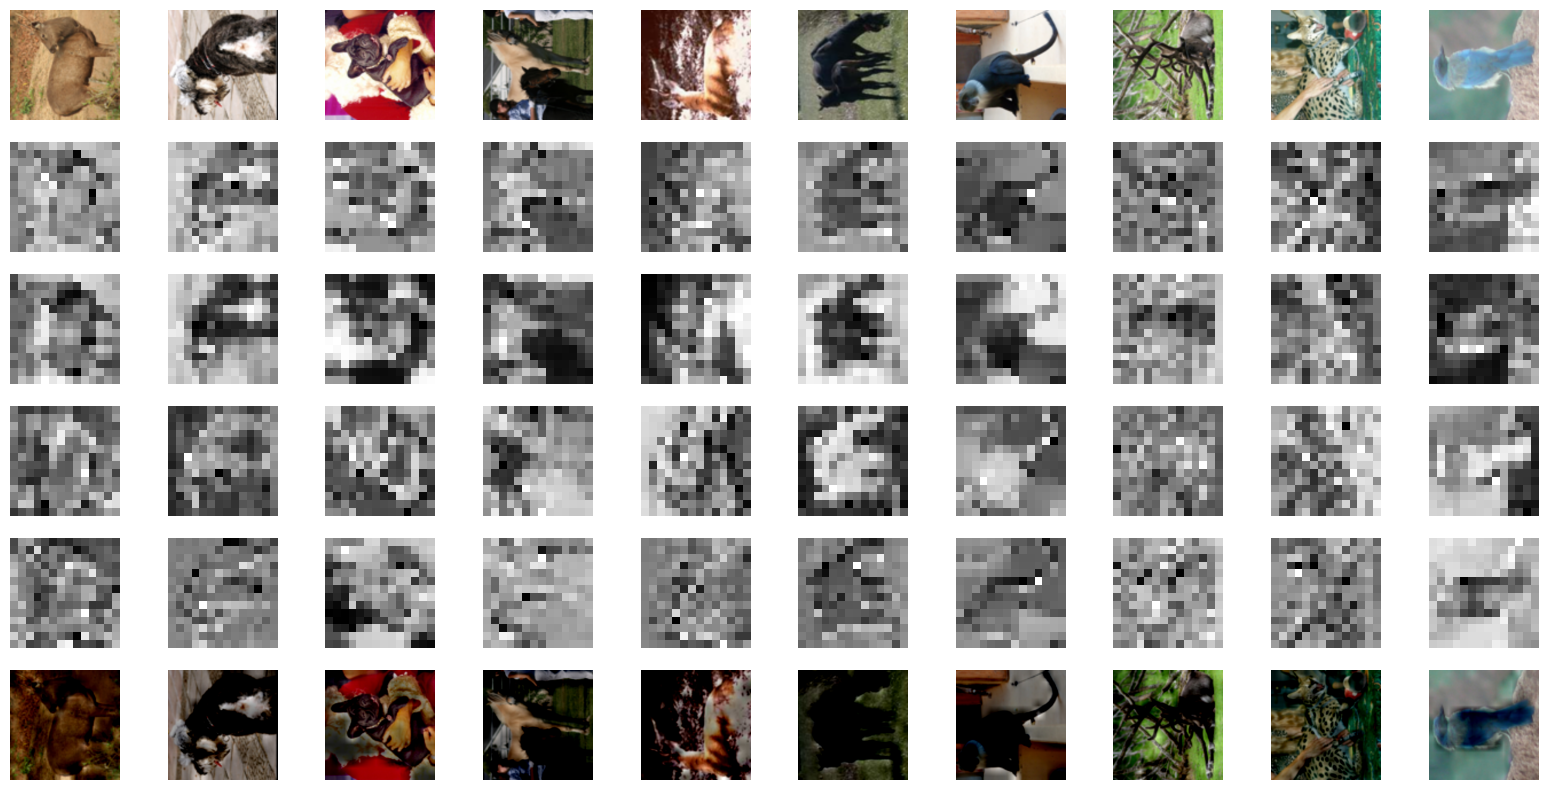

In [725]:
plt.figure(figsize = (20,10))
import cv2

with torch.no_grad():  # validation 과정 no_grad()를 통해 Gradient 계산 안함.
    # validloder에 넣어둔 값 들고오기
    for inputs, labels in testloader:
        # 위에서 train 후 validation 실행. train한번 당 validation 1번 실행.
        inputs, labels = inputs.to(device), labels.to(device) # 우선 GPU에 validation set 올리기        
        for idxs in range(1, 11):
            plt.subplot(6, 10, idxs)
            plt.axis('off')
            plt.imshow(inputs[idxs].cpu().T)
        inputs_r = rearrange(inputs, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
        logits = model2.forward(inputs_r) # validation set인 input값을 넣어서 실행
        print(logits.__len__())
        heads = 7
        # print(logits.__len__())
        # print(logits[0].shape) 
        for idxs in range(1, 11):
            # img = logits[1][idxs].reshape(197, 768)[1: ].reshape(3,224,224)
            img = logits[0][idxs][heads][:, 0].reshape(14,14)
            plt.subplot(6, 10,idxs+10)
            plt.axis('off')
            plt.imshow(img.cpu().numpy().T, cmap = 'gray')
        for idxs in range(1, 11):
            # img = logits[1][idxs].reshape(197, 768)[1: ].reshape(3,224,224)
            img = logits[1][idxs][heads][:, 0].reshape(14,14)
            plt.subplot(6, 10,idxs+20)
            plt.axis('off')
            plt.imshow(img.cpu().numpy().T, cmap = 'gray')
        for idxs in range(1, 11):
            # img = logits[1][idxs].reshape(197, 768)[1: ].reshape(3,224,224)
            img = logits[2][idxs][heads][:, 0].reshape(14,14)
            # img_color = cv2.resize(img.cpu().numpy(), (224,224))
            plt.subplot(6, 10,idxs+30)
            plt.axis('off')
            plt.imshow(img.cpu().numpy().T, cmap = 'gray')

        for idxs in range(1, 11):
            # img = logits[1][idxs].reshape(197, 768)[1: ].reshape(3,224,224)
            img = logits[3][idxs][heads][:, 0].reshape(14,14)
            # img_color = cv2.resize(img.cpu().numpy(), (224,224))
            # img_color = cv2.cvtColor(img_color, cv2.COLOR_GRAY2BGR)
            plt.subplot(6, 10,idxs+40)
            plt.axis('off')
            plt.imshow(img.cpu().numpy().T, cmap = 'gray')
            # plt.imshow(np.max(img_color.mean(), img_color) + inputs[idxs].cpu().numpy().T, cmap = 'gray')

        for idxs in range(1, 11):
            # img = logits[1][idxs].reshape(197, 768)[1: ].reshape(3,224,224)
            img = logits[3][idxs][heads][:, 0].reshape(14,14)
            img_color = cv2.resize(img.cpu().numpy(), (224,224))
            img_color = cv2.rotate(img_color, cv2.ROTATE_90_COUNTERCLOCKWISE)
            img_color = cv2.cvtColor(img_color, cv2.COLOR_GRAY2BGR)
            img_color = cv2.flip(img_color, 0)

            plt.subplot(6, 10,idxs+50)
            plt.axis('off')
            plt.imshow(inputs[idxs].cpu().numpy().T - ((img_color-img_color.min())/(img_color.min() - img_color.max())) - 0.9, cmap = 'gray')
            # plt.imshow(img_color[:, :, 0], cmap = 'gray')
        plt.show()

        break